# ¿Es menor de edad la persona que quiere comprar alcohol?

La cadena de supermercados Good Seed quiere asegurarse de no vender alcohol a personas menores de edad a través del uso de las cámaras equipadas en el área de pago. Nos piden realizar una evaluación y usar métodos de visión artificial para determinar la edades de una persona a partir de una foto.

Para lograr este objetivo, diseñaremos y evaluaremos un modelo de aprendizaje automático destinado a estimar la edad de individuos. Utilizaremos un conjunto de datos compuesto por fotografías de personas acompañadas de sus respectivas edades para entrenar nuestro modelo.

**Tabla de contenido:**

1. Inicialización
2. Carga de datos
3. EDA
4. Modelado
5. Script GPU
6. Conclusiones

El conjunto de datos se almacena en la carpeta `/datasets/faces/`:
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 

## Inicialización

In [1]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image

## Carga los datos

In [2]:
# Cargar datos
labels = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
# Ver sample de data
labels.sample(10)

,file_name,real_age
6471,006475.jpg,12
5760,005760.jpg,52
2137,002137.jpg,71
4656,004656.jpg,25
490,000490.jpg,23
3528,003528.jpg,11
5215,005215.jpg,47
770,000770.jpg,14
7297,007318.jpg,25
4021,004021.jpg,32


In [4]:
# Ver info de data
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# Verificar estadísticas descriptivas
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Al parecer, el máximo y mínimo de edad se encuentra dentro de un rango razonable y el promedio se establece en alrededor de los 31 años. Ahora vemos las distribución de la edad usando un histograma y un gráfico boxplot.

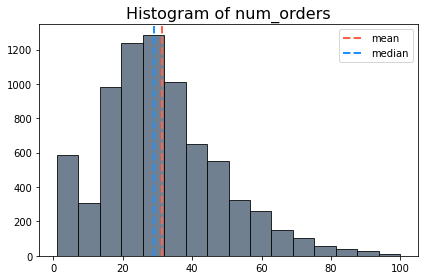

In [6]:
# Graficar Histograma de 'real_age'
plt.hist(labels['real_age'], bins=16, color='slategray', edgecolor="black", linewidth=0.8)

# Dibujar las líneas verticales para la media y la mediana
mean_val = labels['real_age'].mean()
median_val = labels['real_age'].median()
mean_line = plt.axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
median_line = plt.axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

# Agregar la leyenda
plt.legend([mean_line, median_line], ['mean', 'median'])
plt.title(f'Histogram of num_orders', fontsize=16)

plt.tight_layout()
plt.show()

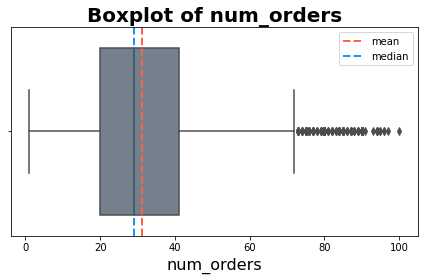

In [7]:
# Graficar Boxplot de 'real_age'
sns.boxplot(x=labels['real_age'], color='slategray')
plt.title(f'Boxplot of num_orders', fontsize=20, weight='bold')
plt.xlabel('num_orders', fontsize=16)

# Dibujar las líneas verticales para la media y la mediana
mean_val = labels['real_age'].mean()
median_val = labels['real_age'].median()
mean_line = plt.axvline(mean_val, color='tomato', linestyle='dashed', linewidth=2)
median_line = plt.axvline(median_val, color='dodgerblue', linestyle='dashed', linewidth=2)

# Agregar la leyenda
plt.legend([mean_line, median_line], ['mean', 'median'])

plt.tight_layout()
plt.show()

Se observa que la distribución de la edad sigue un sesgo positivo (media > mediana), donde la mayoría de los valores se concentran en las edades más bajas y específicamente entre los 20 y 40 años. Asimsimo, se muestran outliers a partir de alrededor de los 70 años.

Por último, veamos el tamaño de matriz de algunas imágenes y las diferentes edades de estas para obtener una muestra general de nuestro conjunto de datos.

Edad: 30
001499.jpg
Matriz: (191, 190, 3)


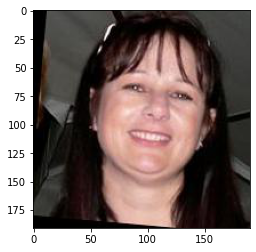

Edad: 45
002095.jpg
Matriz: (364, 364, 3)


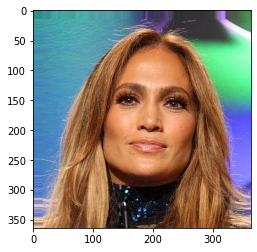

Edad: 68
002030.jpg
Matriz: (776, 776, 3)


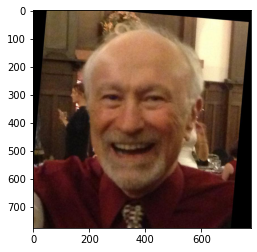

Edad: 32
001532.jpg
Matriz: (517, 517, 3)


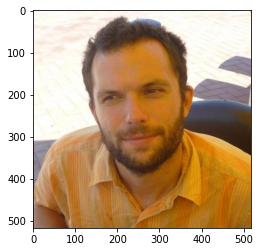

Edad: 15
003998.jpg
Matriz: (287, 287, 3)


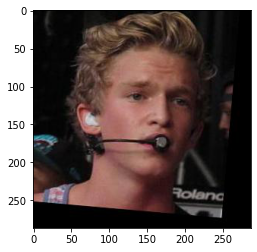

Edad: 23
005532.jpg
Matriz: (539, 538, 3)


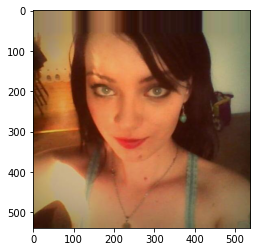

Edad: 70
003030.jpg
Matriz: (1442, 1442, 3)


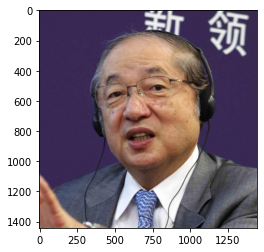

Edad: 57
006000.jpg
Matriz: (409, 409, 3)


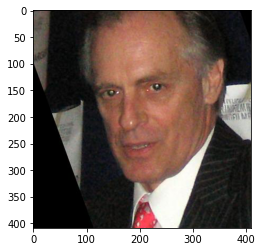

Edad: 45
006586.jpg
Matriz: (713, 713, 3)


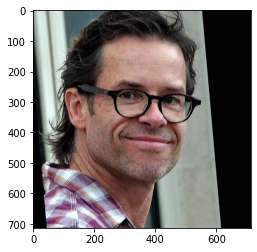

Edad: 62
005436.jpg
Matriz: (378, 379, 3)


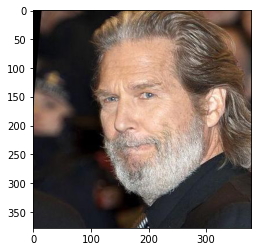

Edad: 13
006773.jpg
Matriz: (234, 234, 3)


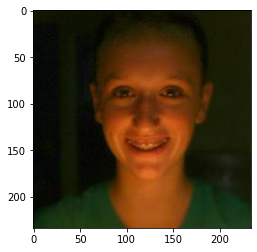

Edad: 40
006410.jpg
Matriz: (191, 190, 3)


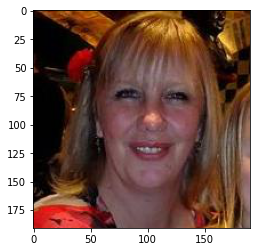

Edad: 61
007184.jpg
Matriz: (510, 509, 3)


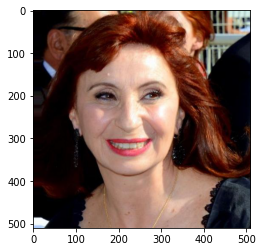

Edad: 50
005313.jpg
Matriz: (965, 966, 3)


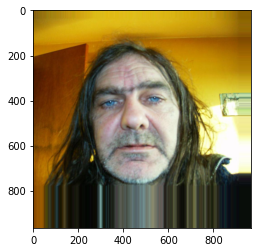

Edad: 42
003114.jpg
Matriz: (679, 679, 3)


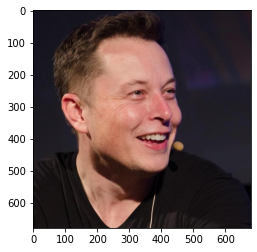

In [8]:
# Imprimir imágenes
for index, row in labels.sample(15).iterrows():
    age = row['real_age']
    file_name = row['file_name']
    image = Image.open(f"/datasets/faces/final_files/{file_name}")
    array = np.array(image)
    print(f'Edad: {age}')
    print(file_name)
    print(f'Matriz: {array.shape}')
    plt.imshow(array)
    plt.show() 

Al parecer las imágenes tienen diferentes tamaños donde el color se encuentra en la tercera coordenada de la imagen. Asimismo, las imágenes aparentan las edades descritas de las mismas.

### Conclusiones

Nuestros datos no presentan ningún incoveniente que debamos tratar hasta el momento y las columnas representan los tipos correctos de datos. La distribución de la edad sigue un sesgo positivo y no muestra algún valor atípico, las edades se encuentran dentro de un rango razonable. Dicho esto podemos usar nuestra data para la creación de modelos.

## Modelado

Ahora definiremos las funciones para entrenar nuestro modelo. Luego haremos un script donde se contengan todas las funciones y podremos ejecutar nuestro modelo.

In [10]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1/255.)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='training',
            seed=12345) 

    return train_gen_flow

In [11]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='validation',
            seed=12345)
    
    return test_gen_flow

Nuestro modelo será basado en la arquitectura ResNet50 como su columna vertebral (backbone) para el aprendizaje de características usando ResNet50 y ReLu como activación. Utilizamos el optimizador Adam, utilizando una tasa de aprendizaje de 0.0001, y para minimizar el error cuadrático medio (MSE) durante el entrenamiento, mientras que también se monitorea el error absoluto medio (MAE) como métrica.

In [12]:
def create_model(input_shape=(224, 224, 3)):
    """
    Define el modelo
    """
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo dados los parámetros
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

## Script GPU

Debido a que es necesario probar nuestro modelo en un GPU, crearemos un script para que pueda ser ejecutado en el mismo. Los resultados de la ejecución del modelo serán presentados más adelante.

In [14]:
# Script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Los resultados los motraremos a continuación:

```bash
Train for 475 steps, validate for 119 steps
Epoch 1/20
2023-09-03 13:32:23.487161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-03 13:32:24.406391: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
475/475 - 74s - loss: 172.0979 - mae: 9.5223 - val_loss: 296.7791 - val_mae: 12.7981
Epoch 2/20
475/475 - 52s - loss: 66.4389 - mae: 6.1015 - val_loss: 43.6792 - val_mae: 5.1228
Epoch 3/20
475/475 - 52s - loss: 37.9759 - mae: 4.7325 - val_loss: 27.8932 - val_mae: 3.8074
Epoch 4/20
475/475 - 52s - loss: 24.5793 - mae: 3.7883 - val_loss: 24.1041 - val_mae: 3.6553
Epoch 5/20
475/475 - 52s - loss: 17.2174 - mae: 3.1677 - val_loss: 29.7706 - val_mae: 4.2509
Epoch 6/20
475/475 - 52s - loss: 12.9435 - mae: 2.7433 - val_loss: 23.0970 - val_mae: 3.6948
Epoch 7/20
475/475 - 52s - loss: 11.0706 - mae: 2.5028 - val_loss: 12.4775 - val_mae: 2.6290
Epoch 8/20
475/475 - 52s - loss: 11.2355 - mae: 2.5465 - val_loss: 23.5196 - val_mae: 3.8350
Epoch 9/20
475/475 - 52s - loss: 11.6299 - mae: 2.5919 - val_loss: 13.7737 - val_mae: 2.7593
Epoch 10/20
475/475 - 52s - loss: 11.0669 - mae: 2.4957 - val_loss: 16.0467 - val_mae: 2.9128
Epoch 11/20
475/475 - 52s - loss: 9.7658 - mae: 2.3427 - val_loss: 12.6743 - val_mae: 2.6852
Epoch 12/20
475/475 - 52s - loss: 8.7416 - mae: 2.2424 - val_loss: 9.6283 - val_mae: 2.3377
Epoch 13/20
475/475 - 52s - loss: 7.6843 - mae: 2.0987 - val_loss: 19.1494 - val_mae: 3.4794
Epoch 14/20
475/475 - 52s - loss: 7.5941 - mae: 2.0769 - val_loss: 11.2476 - val_mae: 2.4749
Epoch 15/20
475/475 - 52s - loss: 8.9542 - mae: 2.2496 - val_loss: 12.6785 - val_mae: 2.7033
Epoch 16/20
475/475 - 52s - loss: 9.2296 - mae: 2.3073 - val_loss: 14.7957 - val_mae: 2.7251
Epoch 17/20
475/475 - 52s - loss: 7.6439 - mae: 2.0740 - val_loss: 9.7330 - val_mae: 2.1853
Epoch 18/20
475/475 - 52s - loss: 6.4325 - mae: 1.8648 - val_loss: 8.6543 - val_mae: 2.2069
Epoch 19/20
475/475 - 52s - loss: 5.2205 - mae: 1.7037 - val_loss: 6.8466 - val_mae: 1.9293
Epoch 20/20
475/475 - 52s - loss: 4.7076 - mae: 1.6279 - val_loss: 6.3092 - val_mae: 1.9154
```

Como podemos observar nuestro modelo funciona muy bien, nuestro error absoluto medio para nuestro conjunto de validación es menos de 2 (1.91). Esto quiere decir que si podemos predecir la edad de una persona con una imagen de ella, en este caso usando las cámaras de los supermercados.

Además, la utilidad de nuestro modelo va más allá de simplemente garantizar que no se venda alcohol a menores de edad. También puede emplearse en diversas estrategias de optimización de ventas para supermercados. Por ejemplo, es posible analizar en qué horarios y días de la semana son más frecuentes las compras realizadas por adultos o jóvenes. A partir de esta información, podríamos diseñar ofertas específicas dirigidas a cada grupo, ajustadas al horario o día en que suelen hacer sus compras.

## Conclusiones

Empezamos verificando la distribución de de las edades de nuestro conjunto de edades y verificando una muestra de imágenes para compararlas con su edad descriptiva. Luego, se procedió al modelado donde se crearon distintas funciones para hacer prueba de nuestro modelo. Por último, se creo un script para poder probar nuestro modelo en un GPU y se mostraron los resultados de los mismos. A continuación, se presentan los principales conclusiones del proyecto:

1. **La distribución de las edades sigue un distribución con sesgo positivo, donde la mayoría de las edades se concentra entre los 20 y 40 años de edad**
2. **Nuestro modelo de red neuronal cumplió con las expectativas mínimas y obtuvo un error absoluto medio (MAE) de validación de 1.9154.**